# Project: Classification on the Fashion-MNIST dataset

In this project, we construct a Convolutional Neural Network (CNN) to classify the Fashion-MNIST dataset into its ten different fashion categories. After constructing the CNN, we evaluate and plot the obtained results.

In [97]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T

In [98]:
# Use the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [99]:
# transformations
transform = T.Compose([ T.ToTensor(), T.RandomHorizontalFlip(p=.5), T.Normalize(.5,.5,),])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True,transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

#print(trainset.data[0])

# split the devset into two seperate sets
randidx = np.random.permutation(10000)
devset = Subset(devtest, randidx[:6000])
testset = Subset(devtest, randidx[6000:])

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True )
dev_loader = DataLoader(devset, batch_size=len(devset))
test_loader = DataLoader(testset, batch_size=len(testset))

In [100]:
# check out the size of the datasets
print('Data shapes (train/test/dev set:)')
print(len(trainset))
print(len(devset))
print(len(testset))

# and the range of pixel intensity values
print('\nData value range:')
print(torch.min(trainset.data).item(), torch.max(trainset.data).item())

# instect a batch of the test_loader
X, y = next(iter(test_loader))
print('\nData shapes testset:')
print(X.data.shape)
print(y.shape)
print('\nData value range:')
print( (torch.min(X.data).item(), torch.max(X.data).item()) )


Data shapes (train/test/dev set:)
60000
6000
4000

Data value range:
0 255

Data shapes testset:
torch.Size([4000, 1, 28, 28])
torch.Size([4000])

Data value range:
(-1.0, 1.0)


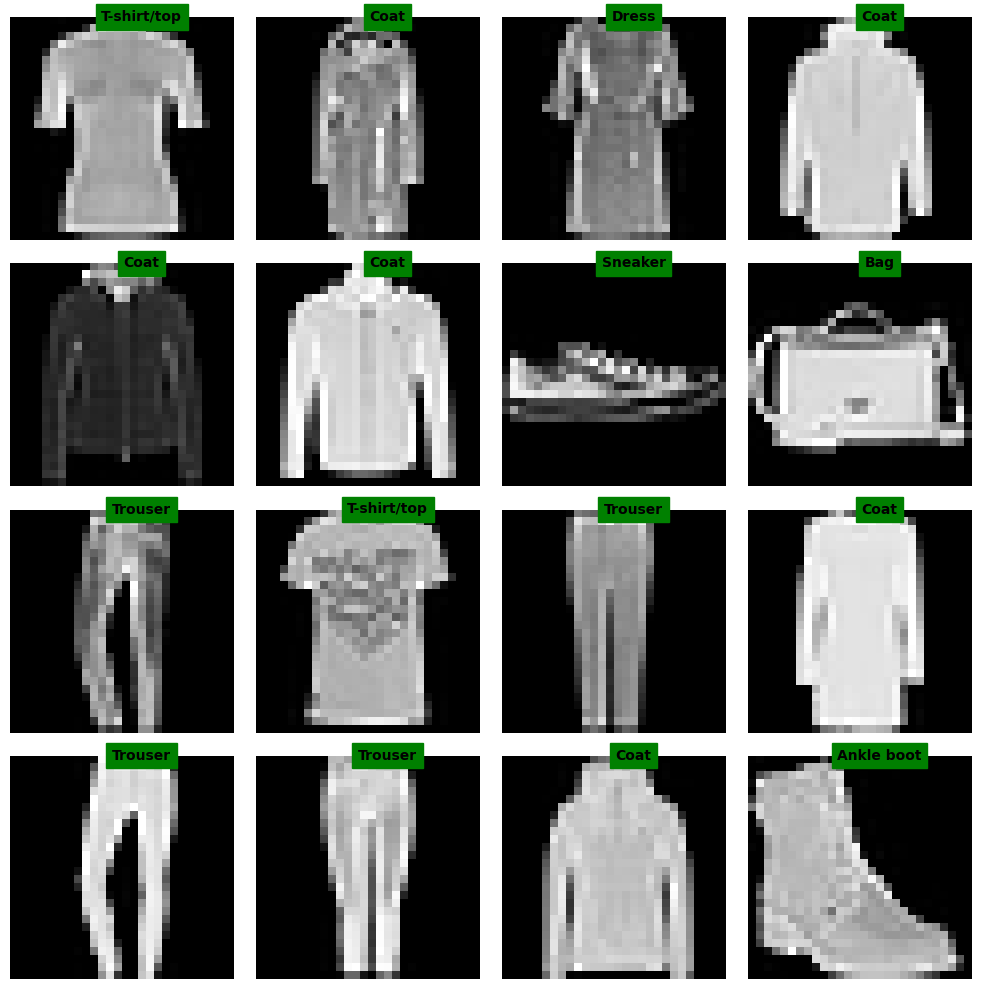

In [103]:
### inspect a few random images

# create a list of random indices
idx_list = np.random.choice(4000, 16)

# plot the images
fig, axs = plt.subplots(4,4, figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract a random image (need to transpose it back to 28x28x1)
  idx = idx_list[i]
  pic = X.data[idx].numpy().transpose((1,2,0))
  pic = pic/2 +.5

  # extract the label of that random image
  label_idx = y[idx_list[i]].item()
  label = trainset.classes[label_idx]

  # plot each image
  ax.imshow(pic, cmap='gray')
  ax.axis('off')
  ax.text(16,0,label, ha ='center', fontweight='bold', color='k', backgroundcolor='g')

plt.tight_layout()
plt.show()

In [104]:
def computeConvOutput(imagesizeW, imagesizeH,padding, k,s):
  """
  Function that computes the output for the convolutional layers.
  """

  # compute the width of the output image
  imagesizeW = np.floor(imagesizeW+2*padding-k[1]/s[1]) +1
  imagesizeW = np.floor(imagesizeW/2)

  # compute the height of the output image
  imagesizeH = np.floor(imagesizeH+2*padding-k[1]/s[1]) +1
  imagesizeH = np.floor(imagesizeH/2)

  return imagesizeW, imagesizeH


In [105]:
X.data[0].shape[2]

28

## Create the Model

In [106]:
def createTheModel(padding, k, s, printtoggle):

  class cnnnet(nn.Module):
    def __init__(self):
      super().__init__()

      # initialize image size
      imagesizeW = X.data[0].shape[1]
      imagesizeH = X.data[0].shape[2]

      self.print = printtoggle

      ### convolutional layers

      # first convolutional layer
      self.conv1 = nn.Conv2d(1,10, kernel_size=5, stride=1, padding=1)

      imagesizeW, imagesizeH = computeConvOutput(imagesizeW, imagesizeH,padding, k,s)

      # second convolutional layer
      self.conv2 = nn.Conv2d(10,20, kernel_size=5, stride=1, padding=1)

      imagesizeW, imagesizeH = computeConvOutput(imagesizeW, imagesizeH,padding, k,s)

      ### fully connected layer
      self.fc1 = nn.Linear(int(imagesizeW)*int(imagesizeH)*self.conv2.out_channels,50)
      self.out = nn.Linear(50,10)

    def forward(self,x):

      # first block: convolution -> maxpool -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(x)
      if self.print: print(f'First CRP block: {list(x.shape)}')

      # second block: convolution -> maxpool -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(x)
      if self.print: print(f'Second CRP block: {list(x.shape)}')

      # reshape for linear layer

      nUnits = x.shape.numel() / x.shape[0]
      x = x.view(-1, int(nUnits))
      if self.print: print(f'Vectorize: {list(x.shape)}')

      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.leaky_relu(self.out(x))
      if self.print: print(f'Vectorize: {list(x.shape)}')

      return x

  # create a model instance
  net = cnnnet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=1e-5)


  return net, lossfun, optimizer


In [107]:
### test the model with one batch
padding = 1
k = (5,5)
s = (1,1)

net, lossfun, optimizer = createTheModel(padding, k, s, printtoggle=True)

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(yHat.shape)

# now lets compute the loss
loss = lossfun(yHat,y)
print(loss.item())

First CRP block: [32, 10, 13, 13]
Second CRP block: [32, 20, 5, 5]
Vectorize: [32, 500]
Vectorize: [32, 10]
torch.Size([32, 10])
2.3067853450775146


## Create a Function that trains the Model

In [108]:
# a function that trains the model

def trainTheModel(padding, k, s, printtoggle):

  # number of epochs
  numepochs = 20

  # create the model
  net, lossfun, optimizer = createTheModel(padding, k, s, printtoggle)

  # initialize loss
  trainAcc = torch.zeros(numepochs)
  devAcc = torch.zeros(numepochs)
  trainLoss = torch.zeros(numepochs)
  devLoss = torch.zeros(numepochs)

  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprob
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1)==y).float()).item() )
    # end of the batch

    # and get the avarage losses and accurcy rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100*np.mean(batchAcc)

    # test performance
    net.eval()
    X, y = next(iter(dev_loader))

    # push the data to the GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get the loss and the accuracy rate from the test batch
    devLoss[epochi] = np.mean(loss.item())
    devAcc[epochi] =  100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item()

  # end epochs

  # function output
  return trainLoss, trainAcc, devLoss, devAcc, net


In [109]:
# initialize parameters
padding = 1
k = (5,5)
s = (1,1)

# run the model
trainLoss, trainAcc, devLoss, devAcc, net = trainTheModel(padding, k, s, printtoggle=False)

In [110]:
X, y = next(iter(test_loader))

# push the data to the GPU
X = X.to(device)
y = y.to(device)

with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# get the loss and the accuracy rate from the test batch
testLoss = np.mean(loss.item())
testAcc =  100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item()

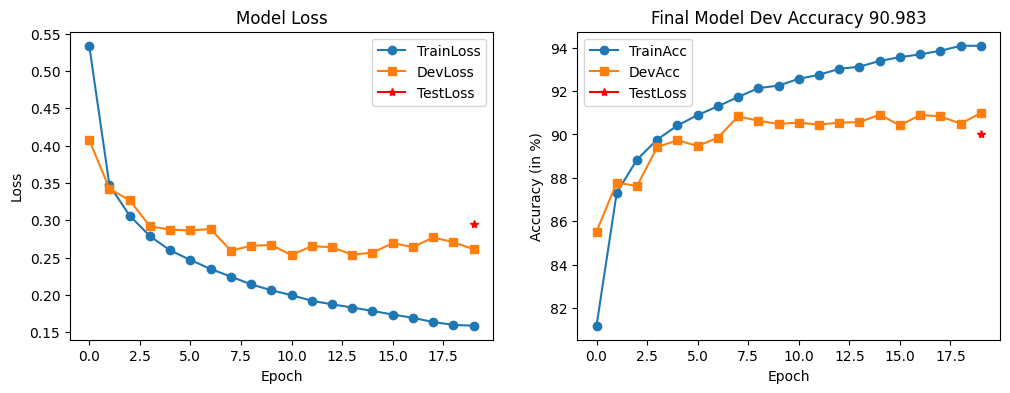

In [112]:
### plot the results
fig, ax = plt.subplots(1,2,figsize=(12,4))

# print the losses
ax[0].plot(trainLoss, label='TrainLoss', marker='o')
ax[0].plot(devLoss, label='DevLoss', marker='s')
ax[0].plot(19,testLoss, marker='*', color='r', label='TestLoss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Calculate the accuracy for the devset
maxDevAcc = np.round(torch.max(devAcc).item(), decimals=3)

# print the accuracy
ax[1].plot(trainAcc, label='TrainAcc', marker='o')
ax[1].plot(devAcc, label='DevAcc', marker='s')
ax[1].plot(19,testAcc, marker='*', color='r', label='TestLoss')
ax[1].set_title("Final Model Dev Accuracy {0}".format( maxDevAcc))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (in %)')
ax[1].legend()

plt.show()

## Refecrences:
https://www.udemy.com/course/deeplearning_x/